<a href="https://colab.research.google.com/github/Sayak007/Covid-19-Forecast-Model/blob/master/FB_prophet_COVID_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import requests
# to parse json contents
import json
# to parse csv files
import csv

# for numerical operations
import numpy as np
# to store and analysis data in dataframes
import pandas as pd
from dateutil.parser import parse 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn import preprocessing, svm
## For stationarity test and decomposition
import statsmodels.tsa.api as smt
import statsmodels.api as sm

In [12]:
dateparse = lambda dates: datetime.strptime(str(dates)+"2020", '%d %B %Y')
cov = pd.read_csv('https://api.covid19india.org/csv/latest/case_time_series.csv',parse_dates=['Date'],date_parser=dateparse)
cov.to_csv('nation_level_daily.csv')
cov.tail()

,Date,Daily Confirmed,Total Confirmed,Daily Recovered,Total Recovered,Daily Deceased,Total Deceased
138,2020-06-16,11086,354161,7226,187550,2004,11922
139,2020-06-17,13108,367269,6890,194440,341,12263
140,2020-06-18,13829,381098,10741,205181,343,12606
141,2020-06-19,14740,395838,9029,214210,364,12970
142,2020-06-20,15898,411736,13972,228182,308,13278


In [13]:
import fbprophet

In [14]:
# Prophet requires columns ds (Date) and y (value)
cov2=cov.rename(columns={'Date': 'ds', 'Daily Confirmed': 'y'},errors="raise")
# Make the prophet model and fit on the data
cov2_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
cov2_prophet.fit(cov2)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [15]:
# Make a future dataframe for 15 days
cov2_forecast = cov2_prophet.make_future_dataframe(periods=15, freq='D')
# Make predictions
cov2_forecast = cov2_prophet.predict(cov2_forecast)

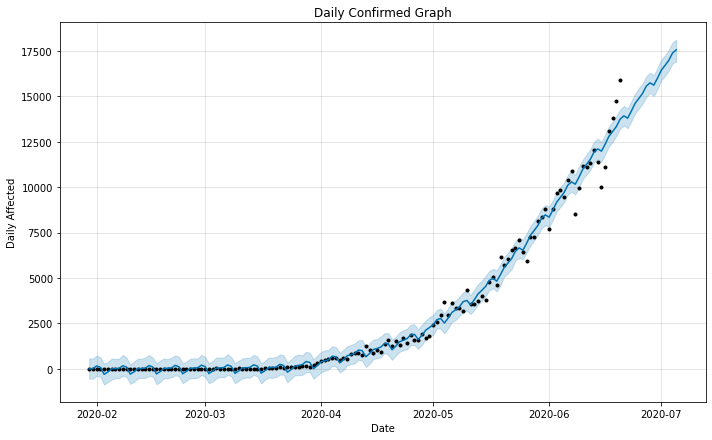

In [16]:
cov2_prophet.plot(cov2_forecast, xlabel = 'Date', ylabel = 'Daily Affected')
plt.title('Daily Confirmed Graph');

In [17]:
from sklearn.metrics import mean_squared_error
from math import sqrt
print(cov2_forecast.tail(30))
cov2_forecast.columns

            ds         trend  ...  multiplicative_terms_upper          yhat
128 2020-06-06   9917.593472  ...                         0.0  10110.360183
129 2020-06-07  10177.302012  ...                         0.0  10289.805051
130 2020-06-08  10437.010551  ...                         0.0  10163.439871
131 2020-06-09  10696.719091  ...                         0.0  10553.895795
132 2020-06-10  10956.427631  ...                         0.0  10984.065017
133 2020-06-11  11216.136171  ...                         0.0  11249.652491
134 2020-06-12  11475.844711  ...                         0.0  11525.815230
135 2020-06-13  11735.553251  ...                         0.0  11928.319961
136 2020-06-14  11995.261790  ...                         0.0  12107.764830
137 2020-06-15  12254.970330  ...                         0.0  11981.399649
138 2020-06-16  12514.678870  ...                         0.0  12371.855574
139 2020-06-17  12774.387410  ...                         0.0  12802.024796
140 2020-06-

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [18]:
cov3_forecast=cov2_forecast.iloc[0:143]
rms = sqrt(mean_squared_error(cov['Daily Confirmed'], cov3_forecast.yhat))
print(rms)

428.99216139664816


In [19]:
rms1 = sqrt(mean_squared_error(cov['Daily Confirmed'], cov3_forecast.trend))
print(rms1)

453.01948947174634


In [20]:
def find_outliers(ts, perc=0.01, figsize=(15,5)):
    ## fit svm
    scaler = preprocessing.StandardScaler()
    ts_scaled = scaler.fit_transform(ts.values.reshape(-1,1))
    model = svm.OneClassSVM(nu=perc, kernel="rbf", gamma=0.01)
    model.fit(ts_scaled)
    ## dtf output
    dtf_outliers = ts.to_frame(name="ts")
    dtf_outliers["index"] = range(len(ts))
    dtf_outliers["outlier"] = model.predict(ts_scaled)
    dtf_outliers["outlier"] = dtf_outliers["outlier"].apply(lambda
                                              x: 1 if x==-1 else 0)
    ## plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.set(title="Outliers detection: found"
           +str(sum(dtf_outliers["outlier"]==1)))
    ax.plot(dtf_outliers["index"], dtf_outliers["ts"],
            color="black")
    ax.scatter(x=dtf_outliers[dtf_outliers["outlier"]==1]["index"],
               y=dtf_outliers[dtf_outliers["outlier"]==1]['ts'],
               color='red')
    ax.grid(True)
    plt.show()
    return dtf_outliers

In [21]:
def remove_outliers(ts, outliers_idx, figsize=(15,5)):
    ts_clean = ts.copy()
    ts_clean.loc[outliers_idx] = np.nan
    ts_clean = ts_clean.interpolate(method="linear")
    ax = ts.plot(figsize=figsize, color="red", alpha=0.5,
         title="Remove outliers", label="original", legend=True)
    ts_clean.plot(ax=ax, grid=True, color="black",
                  label="interpolated", legend=True)
    plt.show()
    return ts_clean

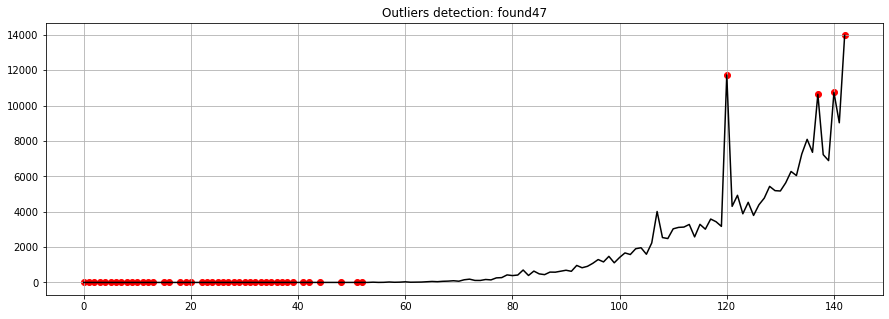

In [22]:
dtf_outliers = find_outliers(cov['Daily Recovered'], perc=0.05)

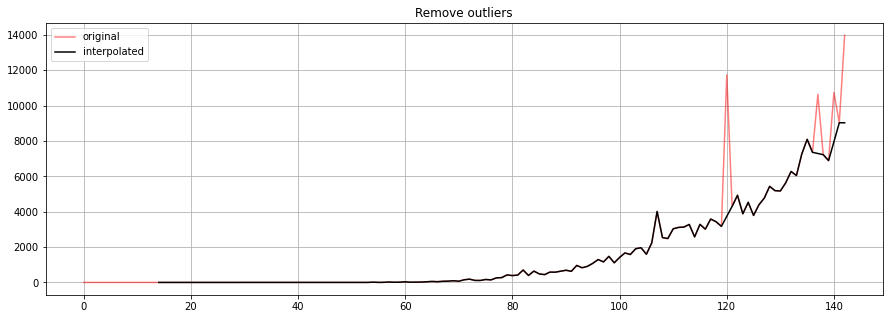

In [23]:
outliers_index_pos = dtf_outliers[dtf_outliers["outlier"]==1].index
cov_removed=remove_outliers(cov['Daily Recovered'],outliers_idx=outliers_index_pos)

In [24]:
print(cov_removed)

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
        ...  
138    7226.0
139    6890.0
140    7959.5
141    9029.0
142    9029.0
Name: Daily Recovered, Length: 143, dtype: float64


In [25]:
cov['D R Removed']=cov_removed
print(cov)


          Date  Daily Confirmed  ...  Total Deceased  D R Removed
0   2020-01-30                1  ...               0          NaN
1   2020-01-31                0  ...               0          NaN
2   2020-02-01                0  ...               0          NaN
3   2020-02-02                1  ...               0          NaN
4   2020-02-03                1  ...               0          NaN
..         ...              ...  ...             ...          ...
138 2020-06-16            11086  ...           11922       7226.0
139 2020-06-17            13108  ...           12263       6890.0
140 2020-06-18            13829  ...           12606       7959.5
141 2020-06-19            14740  ...           12970       9029.0
142 2020-06-20            15898  ...           13278       9029.0

[143 rows x 8 columns]


In [26]:
# Prophet requires columns ds (Date) and y (value)
cov3=cov.rename(columns={'Date': 'ds', 'D R Removed': 'y'},errors="raise")
# Make the prophet model and fit on the data
cov31_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
cov31_prophet.fit(cov3)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [27]:
# Make a future dataframe for 15 days
cov31_forecast = cov31_prophet.make_future_dataframe(periods=15, freq='D')
# Make predictions
cov31_forecast = cov31_prophet.predict(cov3_forecast)

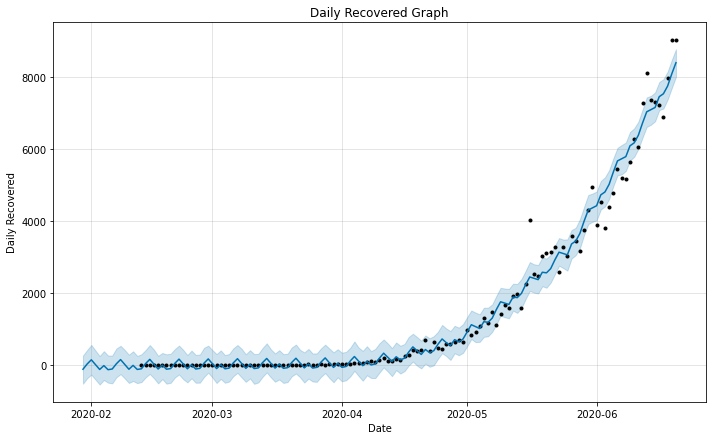

In [28]:
cov31_prophet.plot(cov31_forecast, xlabel = 'Date', ylabel = 'Daily Recovered')
plt.title('Daily Recovered Graph');

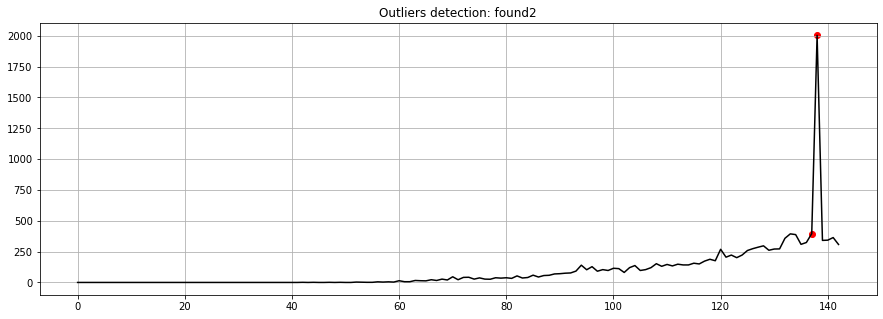

In [29]:
dc_outliers = find_outliers(cov['Daily Deceased'], perc=0.05)

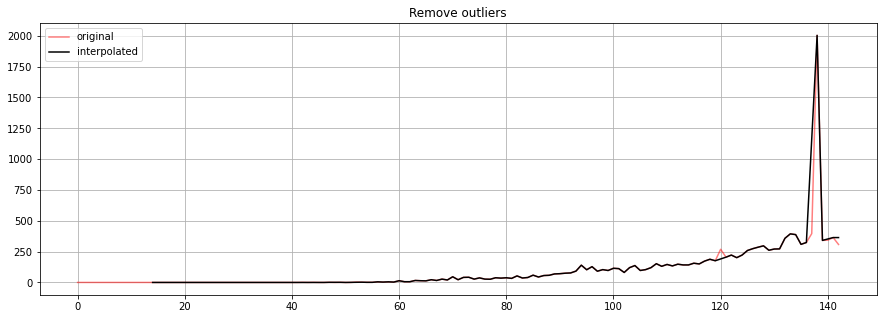

In [30]:
outliers_index_pos = dtf_outliers[dtf_outliers["outlier"]==1].index
cov_removed_dc=remove_outliers(cov['Daily Deceased'],outliers_idx=outliers_index_pos)

In [31]:
cov['D R Dec']=cov_removed_dc
print(cov)

          Date  Daily Confirmed  ...  D R Removed  D R Dec
0   2020-01-30                1  ...          NaN      NaN
1   2020-01-31                0  ...          NaN      NaN
2   2020-02-01                0  ...          NaN      NaN
3   2020-02-02                1  ...          NaN      NaN
4   2020-02-03                1  ...          NaN      NaN
..         ...              ...  ...          ...      ...
138 2020-06-16            11086  ...       7226.0   2004.0
139 2020-06-17            13108  ...       6890.0    341.0
140 2020-06-18            13829  ...       7959.5    352.5
141 2020-06-19            14740  ...       9029.0    364.0
142 2020-06-20            15898  ...       9029.0    364.0

[143 rows x 9 columns]


In [32]:
# Prophet requires columns ds (Date) and y (value)
cov_dc=cov.rename(columns={'Date': 'ds', 'D R Dec': 'y'},errors="raise")
# Make the prophet model and fit on the data
cov41_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
cov41_prophet.fit(cov_dc)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [33]:
# Make a future dataframe for 15 days
cov41_forecast = cov41_prophet.make_future_dataframe(periods=15, freq='D')
# Make predictions
cov41_forecast = cov41_prophet.predict(cov41_forecast)

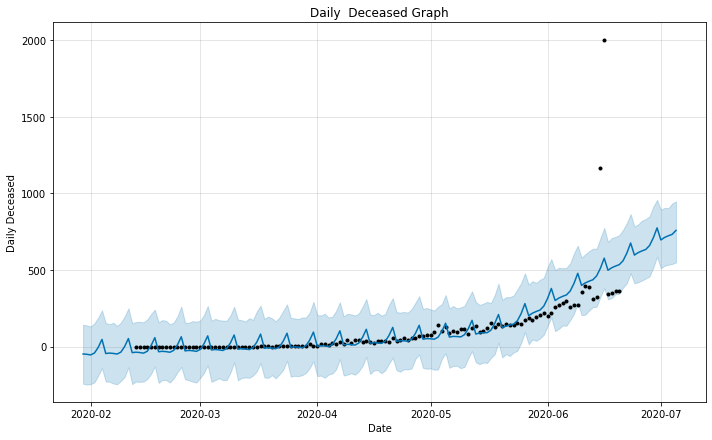

In [34]:
cov41_prophet.plot(cov41_forecast, xlabel = 'Date', ylabel = 'Daily Deceased')
plt.title('Daily  Deceased Graph');

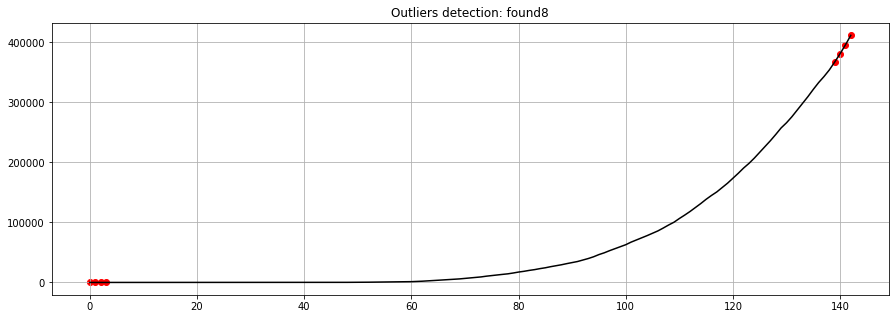

In [35]:
tc_outliers = find_outliers(cov['Total Confirmed'], perc=0.05)

In [79]:
covtc=cov.iloc[-15:]
# Prophet requires columns ds (Date) and y (value)
cov_tc=covtc.rename(columns={'Date': 'ds', 'Total Confirmed': 'y'},errors="raise")
# Make the prophet model and fit on the data
cov51_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
cov51_prophet.fit(cov_tc)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


In [80]:
# Make a future dataframe for 15 days
cov51_forecast = cov51_prophet.make_future_dataframe(periods=15, freq='D')
# Make predictions
cov51_forecast = cov51_prophet.predict(cov51_forecast)

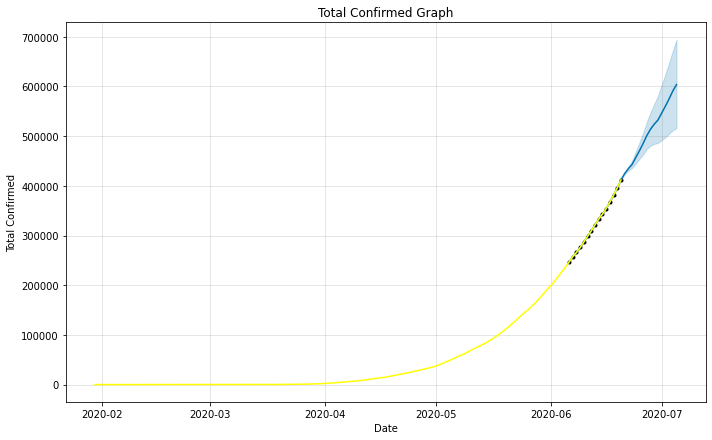

In [81]:
cov51_prophet.plot(cov51_forecast, xlabel = 'Date', ylabel = 'Total Confirmed')
plt.plot(cov['Date'],cov['Total Confirmed'],color='yellow')
plt.title('Total Confirmed Graph');

In [82]:
cov52_forecast=cov51_forecast.iloc[0:15]
rms = sqrt(mean_squared_error(covtc['Total Confirmed'], cov52_forecast.yhat))
print(rms)

1.5934801223786229e-09


In [55]:
cov51_forecast.tail(30)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-06-06,243162.452379,246602.999998,246603.000001,243162.452379,243162.452379,3440.547621,3440.547621,3440.547621,3440.547621,3440.547621,3440.547621,0.0,0.0,0.0,246603.000000
1,2020-06-07,254032.658729,257484.999999,257485.000002,254032.658729,254032.658729,3452.341271,3452.341271,3452.341271,3452.341271,3452.341271,3452.341271,0.0,0.0,0.0,257485.000000
2,2020-06-08,265315.925275,266020.999998,266021.000002,265315.925275,265315.925275,705.074725,705.074725,705.074725,705.074725,705.074725,705.074725,0.0,0.0,0.0,266021.000000
3,2020-06-09,279736.620280,276001.999999,276002.000002,279736.620280,279736.620280,-3734.620280,-3734.620280,-3734.620280,-3734.620280,-3734.620280,-3734.620280,0.0,0.0,0.0,276002.000000
4,2020-06-10,289775.445479,287157.999998,287158.000001,289775.445479,289775.445479,-2617.445479,-2617.445479,-2617.445479,-2617.445479,-2617.445479,-2617.445479,0.0,0.0,0.0,287158.000000
5,2020-06-11,299884.447779,298292.999998,298293.000001,299884.447779,299884.447779,-1591.447779,-1591.447779,-1591.447779,-1591.447779,-1591.447779,-1591.447779,0.0,0.0,0.0,298293.000000
6,2020-06-12,309253.450079,309598.999998,309599.000001,309253.450079,309253.450079,345.549921,345.549921,345.549921,345.549921,345.549921,345.549921,0.0,0.0,0.0,309599.000000
7,2020-06-13,318197.452379,321637.999999,321638.000001,318197.452379,318197.452379,3440.547621,3440.547621,3440.547621,3440.547621,3440.547621,3440.547621,0.0,0.0,0.0,321638.000000
8,2020-06-14,329590.658729,333042.999998,333043.000002,329590.658729,329590.658729,3452.341271,3452.341271,3452.341271,3452.341271,3452.341271,3452.341271,0.0,0.0,0.0,333043.000000
9,2020-06-15,342369.925275,343074.999999,343075.000001,342369.925275,342369.925275,705.074725,705.074725,705.074725,705.074725,705.074725,705.074725,0.0,0.0,0.0,343075.000000


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


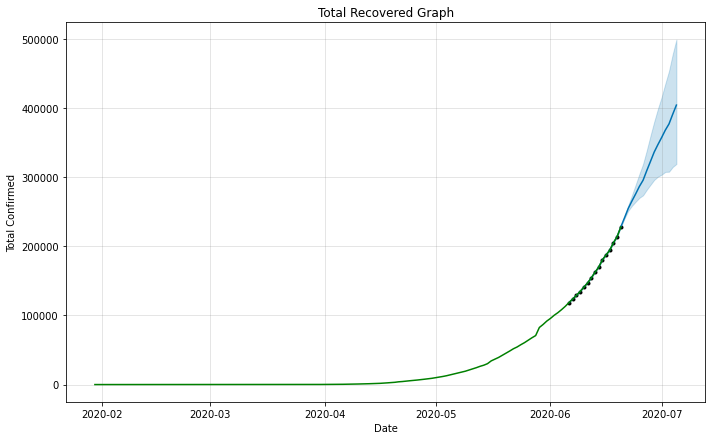

In [63]:
covtr=cov.iloc[-15:]
# Prophet requires columns ds (Date) and y (value)
cov_tr=covtr.rename(columns={'Date': 'ds', 'Total Recovered': 'y'},errors="raise")
# Make the prophet model and fit on the data
cov61_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
cov61_prophet.fit(cov_tc)

# Make a future dataframe for 15 days
cov61_forecast = cov61_prophet.make_future_dataframe(periods=15, freq='D')
# Make predictions
cov61_forecast = cov61_prophet.predict(cov61_forecast)

cov61_prophet.plot(cov61_forecast, xlabel = 'Date', ylabel = 'Total Confirmed')
plt.plot(cov['Date'],cov['Total Recovered'],color="green")
plt.title('Total Recovered Graph');

In [61]:
cov62_forecast=cov61_forecast.iloc[0:15]
rms = sqrt(mean_squared_error(covtc['Total Recovered'], cov62_forecast.yhat))
print(rms)

5.18533971977917e-09


In [62]:
cov61_forecast.tail(20)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
10,2020-06-16,185904.049333,187549.999999,187550.000001,185904.049333,185904.049333,1645.950667,1645.950667,1645.950667,1645.950667,1645.950667,1645.950667,0.0,0.0,0.0,187550.000000
11,2020-06-17,194241.307894,194439.999999,194440.000001,194241.307894,194241.307894,198.692106,198.692106,198.692106,198.692106,198.692106,198.692106,0.0,0.0,0.0,194440.000000
12,2020-06-18,205886.068110,205180.999999,205181.000001,205886.068110,205886.068110,-705.068110,-705.068110,-705.068110,-705.068110,-705.068110,-705.068110,0.0,0.0,0.0,205181.000000
13,2020-06-19,217530.828326,214209.999999,214210.000001,217530.828326,217530.828326,-3320.828326,-3320.828326,-3320.828326,-3320.828326,-3320.828326,-3320.828326,0.0,0.0,0.0,214210.000000
14,2020-06-20,229175.588543,228181.999999,228182.000001,229175.588543,229175.588543,-993.588543,-993.588543,-993.588543,-993.588543,-993.588543,-993.588543,0.0,0.0,0.0,228182.000000
15,2020-06-21,240820.348759,240606.590938,242489.251792,239925.833434,241808.494287,680.757504,680.757504,680.757504,680.757504,680.757504,680.757504,0.0,0.0,0.0,241501.106262
16,2020-06-22,252465.108975,251682.221784,258536.862903,249188.137082,256042.778200,2494.084702,2494.084702,2494.084702,2494.084702,2494.084702,2494.084702,0.0,0.0,0.0,254959.193677
17,2020-06-23,264109.869191,258410.273377,272942.830493,256764.322712,271296.879826,1645.950667,1645.950667,1645.950667,1645.950667,1645.950667,1645.950667,0.0,0.0,0.0,265755.819858
18,2020-06-24,275754.629407,264111.351949,287329.718172,263912.659843,287131.026066,198.692106,198.692106,198.692106,198.692106,198.692106,198.692106,0.0,0.0,0.0,275953.321513
19,2020-06-25,287399.389623,268767.737087,303201.310758,269472.805198,303906.378868,-705.068110,-705.068110,-705.068110,-705.068110,-705.068110,-705.068110,0.0,0.0,0.0,286694.321513


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


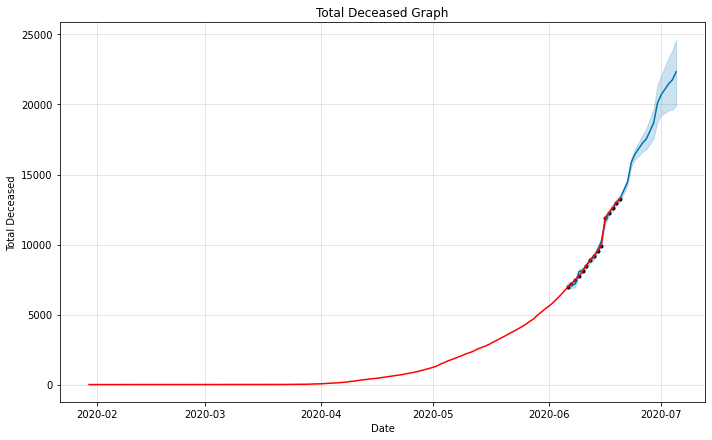

In [74]:
covtd=cov.iloc[-15:]
# Prophet requires columns ds (Date) and y (value)
cov_td=covtd.rename(columns={'Date': 'ds', 'Total Deceased': 'y'},errors="raise")
# Make the prophet model and fit on the data
cov71_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
cov71_prophet.fit(cov_td)

# Make a future dataframe for 15 days
cov71_forecast = cov71_prophet.make_future_dataframe(periods=15, freq='D')
# Make predictions
cov71_forecast = cov71_prophet.predict(cov71_forecast)

cov71_prophet.plot(cov71_forecast, xlabel = 'Date', ylabel = 'Total Deceased')
plt.plot(cov['Date'],cov['Total Deceased'],color='red')
plt.title('Total Deceased Graph');

In [73]:
cov72_forecast=cov71_forecast.iloc[0:15]
rms = sqrt(mean_squared_error(covtd['Total Deceased'], cov72_forecast.yhat))
print(rms)

166.905924651746


In [83]:
cov71_forecast.tail(20)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
10,2020-06-16,11191.742406,11406.220627,11833.979018,11191.742406,11191.742406,421.857278,421.857278,421.857278,421.857278,421.857278,421.857278,0.0,0.0,0.0,11613.599684
11,2020-06-17,11796.944481,12001.437979,12423.250618,11796.944481,11796.944481,424.799768,424.799768,424.799768,424.799768,424.799768,424.799768,0.0,0.0,0.0,12221.744250
12,2020-06-18,12402.146550,12392.352273,12829.794541,12402.146550,12402.146550,208.350124,208.350124,208.350124,208.350124,208.350124,208.350124,0.0,0.0,0.0,12610.496673
13,2020-06-19,13007.348618,12780.670219,13215.260962,13007.348618,13007.348618,-0.601239,-0.601239,-0.601239,-0.601239,-0.601239,-0.601239,0.0,0.0,0.0,13006.747379
14,2020-06-20,13612.550686,13051.828749,13490.506454,13612.550686,13612.550686,-327.316498,-327.316498,-327.316498,-327.316498,-327.316498,-327.316498,0.0,0.0,0.0,13285.234188
15,2020-06-21,14217.752755,13646.438595,14087.107029,14191.905620,14245.189867,-357.329688,-357.329688,-357.329688,-357.329688,-357.329688,-357.329688,0.0,0.0,0.0,13860.423067
16,2020-06-22,14822.954823,14217.740947,14697.785386,14729.125159,14929.133128,-369.759745,-369.759745,-369.759745,-369.759745,-369.759745,-369.759745,0.0,0.0,0.0,14453.195078
17,2020-06-23,15428.156892,15561.100495,16144.364416,15235.654767,15626.710594,421.857278,421.857278,421.857278,421.857278,421.857278,421.857278,0.0,0.0,0.0,15850.014170
18,2020-06-24,16033.358960,16085.970636,16843.752366,15729.861711,16331.409964,424.799768,424.799768,424.799768,424.799768,424.799768,424.799768,0.0,0.0,0.0,16458.158728
19,2020-06-25,16638.561028,16348.478406,17282.441325,16195.936974,17059.597112,208.350124,208.350124,208.350124,208.350124,208.350124,208.350124,0.0,0.0,0.0,16846.911152
